In [1]:
!git clone https://github.com/woldemarg/impulse_classifier

In [2]:
cd impulse_classifier

In [3]:
!pip install --upgrade lightgbm

In [4]:
%matplotlib inline

In [5]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# define random state for reproducibility
RND = 1234
# set sample size
SMP = 5000
# shate of hidden to emulate PU-dataset
n_hidden_share = 0.5
# set test share
EVL = 0.25

X, y = make_classification(
    n_samples=SMP,
    weights=[0.6],
    shuffle=True,
    random_state=RND)

y_pu = y.copy()

pos = np.nonzero(y)[0]
np.random.RandomState(RND).shuffle(pos)

n_hidden = int(y.sum() * n_hidden_share)
y_pu[pos[:n_hidden]] = 0

X_trn, X_tst, y_trn_pu, y_tst_pu, y_trn, y_tst = train_test_split(
    X, y_pu, y, test_size=EVL, random_state=RND, stratify=y_pu)

print(f'Positives in original target: {y.sum()} ({y.mean():.1%})')
print(f'Positives in modified target: {y_pu.sum()} ({y_pu.mean():.1%})')

Positives in original target: 2013 (40.3%)
Positives in modified target: 1007 (20.1%)


In [6]:
from impulse_classifier import ImPULSEClassifier
from lightgbm import LGBMClassifier

base_estimator = LGBMClassifier(
    n_estimators=100,
    random_state=RND,
    force_col_wise=True,
    verbose=-1,
    n_jobs=-1)

impulse_clf = ImPULSEClassifier(
    base_estimator,
    min_lr=0.05,
    max_lr=0.75,
    num_iters=10,
    hold_out_ratio=EVL,
    random_state=RND)

impulse_clf.fit(X_trn, y_trn_pu)

print(f'Share of positives in unlabelled estimated via training: {impulse_clf.prior:.1%}')

Share of positives in unlabelled estimated via training: 21.8%


In [7]:
from sklearn.metrics import confusion_matrix


def compute_confusion_matrix(
        model,
        X_train: np.array,
        y_train: np.array,
        X_test: np.array,
        y_test: np.array) -> np.array:

    test_size = len(y_test)

    pos_index = np.where(y_train)[0]

    train_prob = model.predict_proba(X_train[pos_index])[:, 1]

    pos_labelled_prob = train_prob.mean()

    test_prob = model.predict_proba(X_test)[:, 1]

    conf_matrix = confusion_matrix(y_test, (test_prob > 0.5))

    true_neg, false_pos, false_neg, true_pos = conf_matrix.ravel()

    if model.prior > 0:

        false_pos_odds = ((np.abs(y_test - 1)).sum() *
                          model.prior * pos_labelled_prob)

        true_pos_odds = ((np.abs(y_test - 1)).sum() *
                         model.prior * (1 - pos_labelled_prob))

        false_pos_adj = max(0, false_pos - (false_pos_odds + true_pos_odds))

        true_pos_adj = true_pos + false_pos_odds

        false_neg_adj = false_neg + true_pos_odds

        conf_matrix = np.array(
            [[true_neg, false_pos_adj], [false_neg_adj, true_pos_adj]])

        conf_matrix = (
            np.round(conf_matrix * test_size /
                     conf_matrix.sum()) * conf_matrix.sum() // test_size)

        true_neg_odds = test_size - conf_matrix.sum()

        true_neg_adj = true_neg + true_neg_odds

        conf_matrix[0, 0] = true_neg_adj

    return conf_matrix.astype(int)

In [8]:
def compute_metrics(conf_matrix: np.array) -> tuple:
    tn, fp, fn, tp = conf_matrix.ravel()
    balanced_acc = (tp / (tp + fn) + tn / (tn + fp)) / 2
    rec = tp / (tp + fn)
    prec = tp / (tp + fp)
    return (balanced_acc, rec, prec)

In [9]:
from collections import defaultdict
import pandas as pd

y_prd = impulse_clf.predict(X_tst)

cm_true = confusion_matrix(y_tst, y_prd)

cm_naiv = confusion_matrix(y_tst_pu, y_prd)

cm_adjs = compute_confusion_matrix(
    impulse_clf,
    X_trn,
    y_trn_pu,
    X_tst,
    y_tst_pu)

conf_mtxs = (cm_true, cm_naiv, cm_adjs)

mtx = pd.DataFrame(
    np.concatenate(conf_mtxs),
    index=['true_neg', 'true_pos'] * len(conf_mtxs),
    columns=['pred_neg', 'pred_pos'])

metrics = defaultdict(list)

for i, cm in enumerate(conf_mtxs):
    metrics[i].extend(compute_metrics(cm))

titles = ['True CM', 'PU-naive CM', 'PU-adjusted CM']

ODD = ':\naccuracy {:.1%}\nrecall {:.1%}\nprecision {:.1%}'

cm_titles = [('').join([title, ODD]).format(*metrics[i])
             for i, title in enumerate(titles)]

# https://stackoverflow.com/a/3900001/6025592
mtx['method'] = sum([[title] * 2 for title in cm_titles], [])

In [10]:
import seaborn as sns


def draw_heatmap(data, **kwargs):

    dfr = data.copy()

    dfr.drop(columns=['method'], inplace=True)

    dfr_cnts = [str(v) for v in dfr.values.ravel()]
    dfr_perc = [f'{v:.1%}' for v in dfr.values.ravel() / np.sum(dfr.values)]

    dfr_labs = [f'{v1}\n{v2}' for v1, v2 in zip(dfr_cnts, dfr_perc)]
    dfr_labs = np.asarray(dfr_labs).reshape(dfr.shape)

    sns.heatmap(dfr/dfr.sum().sum(),
                annot=dfr_labs,
                annot_kws={'fontsize': 14},
                fmt='',
                vmin=0,
                vmax=1,
                cbar=False,
                cmap='Blues',
                square=True,
                linewidth=0.75,
                **kwargs)

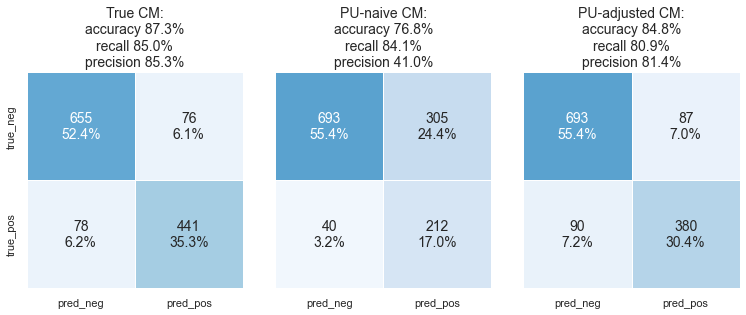

In [11]:
sns.set_theme()

fg = sns.FacetGrid(mtx, col='method', height=4.5, aspect=0.8)

fg.map_dataframe(draw_heatmap)

fg.set_titles(col_template='{col_name}',  size=14)

fg.fig.tight_layout()